In [1]:
# Useful / Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import csv
import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import svm
import warnings;

warnings.filterwarnings('ignore');

In [2]:
# Read the CSV and drop rows that are from older years
# in order to make the dataset more manageable and current.
# Only dropping rows from 2016/17, and this cell should only need
# to be run one time to create the cleaned data file.

with open('US_Accidents_Dec21_updated.csv', 'r') as inp, open('accidents_cleaned.csv', 'w') as out:
    writer = csv.writer(out)
    reader = csv.reader(inp)
    
    # skip the header row
    writer.writerow(next(reader))
    
    for row in reader:
        if "2021" in row[2] or "2020" in row[2] or "2019" in row[2] or "2018" in row[2]:
            writer.writerow(row)

In [3]:
# Load the dataset, this cell might take a minute to finish
# execution due to large size of the csv file.
accidents = pd.read_csv("accidents_cleaned.csv")

In [4]:
# Clean the dataset by dropping unnecessary columns
drop = ["Start_Lat", "Start_Lng", "End_Lat", "End_Lng",
        "Timezone", "Airport_Code", "Number", "Description"]

accidents.drop(columns=drop, inplace=True)

# Convert time columns to datetime formats
accidents['Start_Time'] = pd.to_datetime(accidents['Start_Time'])
accidents['End_Time'] = pd.to_datetime(accidents['End_Time'])
accidents['Weather_Timestamp'] = pd.to_datetime(accidents['Weather_Timestamp'])

In [5]:
# Examine the dataset to determine if it needs to be cleaned in any way.
# We are looking for duplicate rows, NaN/null values, and incorrect data types.

print("----------------------- Examine Data for Cleaning -----------------------")
print()

# Starting with data types...
print("Data types for each column in the dataset:")
print(accidents.dtypes)
print()

# Duplicate rows
print("Number of duplicated rows in the dataset:")
print(accidents.duplicated().sum())
print()

# Null values
print("Number of null values in the dataset:")
print(accidents.isnull().sum())

print()
print("-------------------------------------------------------------------------")

----------------------- Examine Data for Cleaning -----------------------

Data types for each column in the dataset:
ID                               object
Severity                          int64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Distance(mi)                    float64
Street                           object
Side                             object
City                             object
County                           object
State                            object
Zipcode                          object
Country                          object
Weather_Timestamp        datetime64[ns]
Temperature(F)                  float64
Wind_Chill(F)                   float64
Humidity(%)                     float64
Pressure(in)                    float64
Visibility(mi)                  float64
Wind_Direction                   object
Wind_Speed(mph)                 float64
Precipitation(in)               float64
Weather_Condition                object
Am

In [6]:
# Continue to clean the dataset by removing rows with missing values
# Drop rows with null values, using column names printed above
accidents.dropna(subset = ['Street', 'City', 'Zipcode', 'Weather_Timestamp', 'Temperature(F)',
                    'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
                    'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition',
                    'Sunrise_Sunset', 'Civil_Twilight', "Nautical_Twilight", "Astronomical_Twilight"],
                 inplace = True)

# Now reprint the count of null values
print("Number of null values in the dataset:")
print(accidents.isnull().sum())

Number of null values in the dataset:
ID                       0
Severity                 0
Start_Time               0
End_Time                 0
Distance(mi)             0
Street                   0
Side                     0
City                     0
County                   0
State                    0
Zipcode                  0
Country                  0
Weather_Timestamp        0
Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
Turning_Loop             0
Sunrise_Sunset   

In [ ]:
# Continue the cleaning process yet again by converting the catagorical
# variables in the dataset into integer values so that they can run in
# the regression model that we will create
LE = LabelEncoder()
accidents_encoded = accidents.apply(LE.fit_transform)

In [8]:
# Now that the data is cleaned, we can start building the regression model

# Using an ordinary least squares regression model from the statsmodels api will allow
# us to determine which features are most effective at making predictions
# about the servarity of an accident.

# Split the dataset into testing and training data
# We can ignore the ID since it won't have any weight
# on the decision maxing process
features = ["Start_Time", "End_Time", "Distance(mi)", "Street", "Side", "City",
            "County", "State", "Zipcode", "Country", "Weather_Timestamp",
            "Temperature(F)", "Wind_Chill(F)", "Humidity(%)",
            "Pressure(in)", "Visibility(mi)", "Wind_Direction", "Wind_Speed(mph)",
            "Precipitation(in)", "Weather_Condition", "Amenity", "Bump", "Crossing",
            "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station",
            "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop", "Sunrise_Sunset",
            "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight"]

X = accidents_encoded.loc[:, features]
y = accidents_encoded.loc[:, 'Severity']

train_vectors, test_vectors, train_labels, test_labels = train_test_split(X, y, random_state=123, train_size=.75)

In [9]:
# Construct the model using the training labels and vectors
# fit the model and print the summary so that we can evaluate
# the different features based on their P scores
ols_model = sm.OLS(train_labels, sm.add_constant(train_vectors))
result = ols_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               Severity   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     3900.
Date:                Sat, 22 Apr 2023   Prob (F-statistic):               0.00
Time:                        19:46:35   Log-Likelihood:            -6.7101e+05
No. Observations:             1647273   AIC:                         1.342e+06
Df Residuals:                 1647237   BIC:                         1.343e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.68

In [10]:
# Now that we have an evaluation of our factors, we can drop some of the ones
# that don't have as much influence on the prediction. We can determine which
# factors to drop based on their P-scores. We can drop Bump, No_Exit, Roundabout,
# Traffic_Calming, Turning_Loop, Sunrise_Sunset, and Civil_Twilight
features = ["Start_Time", "End_Time", "Distance(mi)", "Street", "Side", "City", "County",
            "State", "Zipcode", "Country", "Weather_Timestamp", "Temperature(F)",
            "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Direction",
            "Wind_Speed(mph)", "Precipitation(in)", "Weather_Condition", "Amenity", "Crossing",
            "Give_Way", "Junction", "Railway", "Station", "Stop", "Traffic_Signal",
            "Nautical_Twilight", "Astronomical_Twilight"]


# And we have to regenerate the training and testing sets
X = accidents_encoded.loc[:, features]
y = accidents_encoded.loc[:, 'Severity']

train_vectors, test_vectors, train_labels, test_labels = train_test_split(X, y, random_state=123, train_size=.75)

In [11]:
# Now we can reconstruct the model with the new set of features and evaluate it
ols_model = sm.OLS(train_labels, sm.add_constant(train_vectors))
result = ols_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               Severity   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     4706.
Date:                Sat, 22 Apr 2023   Prob (F-statistic):               0.00
Time:                        19:46:43   Log-Likelihood:            -6.7102e+05
No. Observations:             1647273   AIC:                         1.342e+06
Df Residuals:                 1647243   BIC:                         1.342e+06
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.68

In [12]:
# Now that we have an initial model, we can calculate some basic 
# statistics and metrics to determine the strength of the initial model

# Calculate the precision, recall and accuracy
values = result.predict(sm.add_constant(test_vectors))
predictions = np.where(values > 0.5, 1, 0)

p_score = precision_score(test_labels, predictions, average='weighted')
r_score = recall_score(test_labels, predictions, average='weighted')

print("----------------------- Initial Evaluation -----------------------\n")
print(f"Precision: {p_score}")
print(f"Recall: {r_score}")

correct = 0
total_samples = len(test_labels)

temp = np.array(test_labels)
for i in range(len(test_labels)):
    if predictions[i] == temp[i]:
        correct += 1

accuracy = correct / total_samples

print(f"Accuracy: {accuracy}")
print("\n------------------------------------------------------------------")

----------------------- Initial Evaluation -----------------------

Precision: 0.8703468329524682
Recall: 0.9329238087606448
Accuracy: 0.9329238087606448

------------------------------------------------------------------


In [13]:
# Now we can build an SVM model in order to compare the 
# performance of a different predictive algorithm to the
# results from the OLS model printed above

# We have to construct the model with a different dataset
# than what was used for the regression model, since
# the size of the original dataset (~1.15 GB) is far
# too large for the machine learning algorithms
# to process in a reasonable timeframe. The dataset
# for this model is around (4.5 mb), which will work
# better in terms of efficiency.

# Step one is to load the dataset 
accidents_2 = pd.read_csv('cleaned.csv')

# Now we can examine the dataset for cleaning
print("----------------------- Examine Data for Cleaning -----------------------")
print()

# Starting with data types...
print("Data types for each column in the dataset:")
print(accidents_2.dtypes)
print()

# Duplicate rows
print("Number of duplicated rows in the dataset:")
print(accidents_2.duplicated().sum())
print()

# Null values
print("Number of null values in the dataset:")
print(accidents_2.isnull().sum())

print()
print("-------------------------------------------------------------------------")

----------------------- Examine Data for Cleaning -----------------------

Data types for each column in the dataset:
Age_band_of_driver         object
Sex_of_driver              object
Educational_level          object
Vehicle_driver_relation    object
Driving_experience         object
Lanes_or_Medians           object
Types_of_Junction          object
Road_surface_type          object
Light_conditions           object
Weather_conditions         object
Type_of_collision          object
Vehicle_movement           object
Pedestrian_movement        object
Cause_of_accident          object
Accident_severity           int64
dtype: object

Number of duplicated rows in the dataset:
390

Number of null values in the dataset:
Age_band_of_driver         0
Sex_of_driver              0
Educational_level          0
Vehicle_driver_relation    0
Driving_experience         0
Lanes_or_Medians           0
Types_of_Junction          0
Road_surface_type          0
Light_conditions           0
Weather_con

In [14]:
# It looks like the only problem is the duplicated rows.
# We can take care of that using the Pandas drop_duplicates() function
accidents_2.drop_duplicates(inplace=True)

# Reexamine duplicate rows
print("Number of duplicated rows in the dataset:")
print(accidents_2.duplicated().sum())

Number of duplicated rows in the dataset:
0


In [15]:
# Now that the data is in good shape, we now just have to
# continue the cleaning process by converting the catagorical
# variables in the dataset into integer values so that they can run in
# the machine learning model that we will create
LE = LabelEncoder()
accidents_2_encoded = accidents_2.apply(LE.fit_transform)

In [18]:
# Now that the data is encoded, we can start building the SVM model.
# Split the dataset into testing and training data
features_svm = ['Age_band_of_driver', 'Sex_of_driver', 'Educational_level',
       'Vehicle_driver_relation', 'Driving_experience', 'Lanes_or_Medians',
       'Types_of_Junction', 'Road_surface_type', 'Light_conditions',
       'Weather_conditions', 'Type_of_collision', 'Vehicle_movement',
       'Pedestrian_movement', 'Cause_of_accident']

X_svm = accidents_2_encoded.loc[:, features_svm]
y_svm = accidents_2_encoded.loc[:, 'Accident_severity']

svm_train_vectors, svm_test_vectors, svm_train_labels, svm_test_labels = \
train_test_split(X_svm, y_svm, random_state=123, train_size=.75)

In [19]:
# We have to determine what the best hyperparameters are.
# in this case, we need values for C, gamma, and the best
# kernel function to use. Running a grid search and fitting it 
# to our training data should take care of this for us.
# vals = [0.01, 0.1, 1.0, 10.0]
# params = {'C': vals, 'gamma': vals, 'kernel': ('linear', 'rbf')}
# svc = svm.SVC()

# search = GridSearchCV(svc, params, n_jobs=4)
# search.fit(svm_train_vectors, svm_train_labels)

# print(search.best_params_)


# This cell took around 5 minutes to run, I'm going to comment it out now that
# it gave us the results, it shouldn't need to be run again

In [20]:
# It's now time to construct the model with our parameters from above
svm_model = svm.SVC(C=0.01, gamma=0.01, kernel='linear')
svm_model.fit(svm_train_vectors, svm_train_labels)
score = svm_model.score(X_svm, y_svm)
print(f"Initial SVM R^2 score: {score}")

Initial SVM R^2 score: 0.8411034714070099


In [21]:
# And now we can evaluate the precision, recall, and accuracy.
# Once we have these values, we'll be able to compare the two
# models to see which performed better at predicting accident severity
svm_predictions = svm_model.predict(svm_test_vectors)

svm_p_score = precision_score(svm_test_labels, svm_predictions, average='weighted')
svm_r_score = recall_score(svm_test_labels, svm_predictions, average='weighted')

print("----------------------- Initial Evaluation -----------------------\n")
print(f"Precision: {svm_p_score}")
print(f"Recall: {svm_r_score}")

correct = 0
total_samples = len(svm_test_labels)

temp = np.array(svm_test_labels)
for i in range(total_samples):
    if svm_predictions[i] == temp[i]:
        correct += 1

svm_accuracy = correct / total_samples

print(f"Accuracy: {svm_accuracy}")
print("\n------------------------------------------------------------------")

----------------------- Initial Evaluation -----------------------

Precision: 0.7073588411758276
Recall: 0.8410462776659959
Accuracy: 0.8410462776659959

------------------------------------------------------------------


In [22]:
# As we can see from the results above, the SVM model didn't perform as
# well as the regression model. It still did pretty well, but overall it
# has lower precision, recall, and accuracy. This could be due to the fact
# that the dataset used for the SVM is much smaller than that of the regression
# model. 

# Now that we know which model performs better, we can run the process again
# over different random states, to get the averages for the three scoring
# metrics we have been using to evalute. 

# This cell takes around 10 minutes to run, so feel free to comment out if possible

# First, define a function
def get_scores(seed, X_data, y_data):
    # Resplit the data with the new seed
    train_v, test_v, train_l, test_l = train_test_split(X_data, y_data, random_state=seed, train_size=.75)
    
    # Create the OLS model
    ols_model = sm.OLS(train_l, sm.add_constant(train_v))
    result = ols_model.fit()
    
    # Now get the scoring metrics
    values = result.predict(sm.add_constant(test_v))
    predictions = np.where(values > 0.5, 1, 0)

    p_score = precision_score(test_l, predictions, average='weighted')
    r_score = recall_score(test_l, predictions, average='weighted')

    correct = 0
    total_samples = len(test_l)

    temp = np.array(test_l)
    for i in range(total_samples):
        if predictions[i] == temp[i]:
            correct += 1

    accuracy = correct / total_samples
    
    return p_score, r_score, accuracy

# Next, define a dictionary to hold the samples
# We can give it the score values we already got for random_state = 123
scores = { 
    "Precision": [0.8703468329524682],
    "Recall": [0.9329238087606448],
    "Accuracy": [0.9329238087606448]
}

# Now we run our function from above and append to the dictionary
# Get 100 samples
for seed in range(124, 225):
    precision, recall, accuracy = get_scores(seed, X, y)
    scores["Precision"].append(precision)
    scores["Recall"].append(recall)
    scores["Accuracy"].append(accuracy)
    
print(scores)

{'Precision': [0.8703468329524682, 0.8709144014897086, 0.8720228827100059, 0.8715433610641495, 0.8713937501019008, 0.8707886368184184, 0.8711591587716245, 0.8703706195357017, 0.8711183635032614, 0.8716351741491501, 0.8717780041154716, 0.8711863561478762, 0.872053494952217, 0.871114963940682, 0.8706526852271385, 0.8708498184971578, 0.8722439831988618, 0.8701055874048493, 0.8712645509694265, 0.8703536290859392, 0.8706492865733423, 0.8709245990232258, 0.8709144014897086, 0.8714379520041059, 0.8721759492941592, 0.8716045692501735, 0.8709823861741777, 0.8712203534652018, 0.8713665494885232, 0.8706832734098096, 0.8720841077317377, 0.8713597494015134, 0.871509357445042, 0.8709245990232258, 0.871169357737968, 0.8705541269602319, 0.8711217630724745, 0.8711795567640125, 0.8706696785956212, 0.8716997862559334, 0.8709653897543058, 0.8717814049715747, 0.8716317735782856, 0.8718358195713743, 0.8715705644370443, 0.8709381958274506, 0.8712747505526812, 0.8715569626975292, 0.8715637635540199, 0.8716929

In [23]:
# Now we can find the averages of the scores in the dictionary
print("----------------------- Average Model Performance -----------------------\n")

avg_pre, avg_re, avg_acc = \
    np.average(scores["Precision"]), np.average(scores["Recall"]), np.average(scores["Accuracy"])

med_pre, med_re, med_acc = \
    np.median(scores["Precision"]), np.median(scores["Recall"]), np.median(scores["Accuracy"])

print(f"The average precision over 100 fits: {avg_pre}")
print(f"The average recall over 100 fits: {avg_re}")
print(f"The average accuracy over 100 fits: {avg_acc}")

print()

print(f"The median precision over 100 fits: {med_pre}")
print(f"The median recall over 100 fits: {med_re}")
print(f"The median accuracy over 100 fits: {med_acc}")

print("\n-------------------------------------------------------------------------")

----------------------- Average Model Performance -----------------------

The average precision over 100 fits: 0.8712075588785929
The average recall over 100 fits: 0.9333849622399788
The average accuracy over 100 fits: 0.9333849622399788

The median precision over 100 fits: 0.8711642582547963
The median recall over 100 fits: 0.9333618045791962
The median accuracy over 100 fits: 0.9333618045791962

-------------------------------------------------------------------------


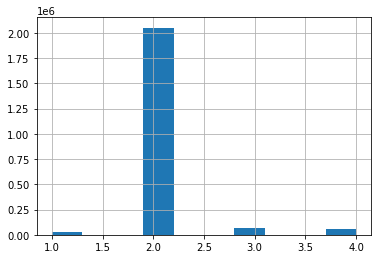

In [24]:
accidents['Severity'].hist()
plt.show()

In [25]:
accidents['Temperature(F)'].describe()

count    2.196365e+06
mean     6.194461e+01
std      1.849858e+01
min     -3.300000e+01
25%      5.000000e+01
50%      6.400000e+01
75%      7.600000e+01
max      1.960000e+02
Name: Temperature(F), dtype: float64

In [26]:
#from the .describe(), it shows that there are outliers in the accidents data so I took sample
#of the large data to minimize possible outliers 

sample = accidents.sample(n=1000)
sample['Temperature(F)'].describe()

count    1000.000000
mean       62.076000
std        18.339096
min        -9.000000
25%        49.000000
50%        64.000000
75%        76.000000
max       108.000000
Name: Temperature(F), dtype: float64

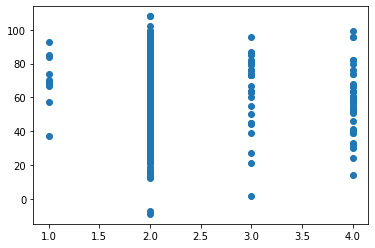

In [27]:
severity = sample['Severity']
temperature = sample['Temperature(F)']

plt.scatter(severity,temperature)
plt.show()

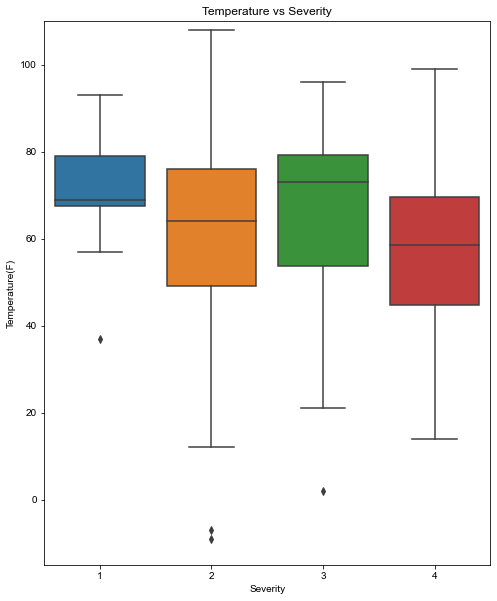

In [28]:
plt.figure(figsize=(8,10))
sns.boxplot(data=sample, y='Temperature(F)', x='Severity').set_title('Temperature vs Severity')
sns.set_style("whitegrid")

plt.ylim(-15, 110)
plt.show()

In [29]:
sample['Wind_Chill(F)'].describe()

count    1000.000000
mean       61.062600
std        20.127756
min       -22.000000
25%        49.000000
50%        64.000000
75%        76.000000
max       108.000000
Name: Wind_Chill(F), dtype: float64

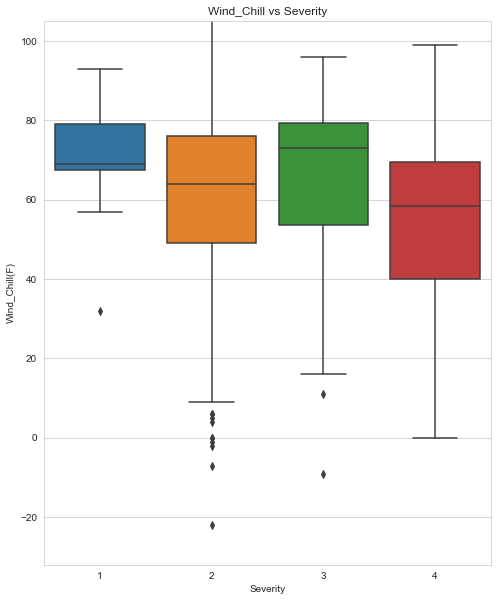

In [30]:
plt.figure(figsize=(8,10))
sns.boxplot(data=sample, y='Wind_Chill(F)', x='Severity').set_title('Wind_Chill vs Severity')
sns.set_style("whitegrid")

plt.ylim(-32, 105)
plt.show()

In [31]:
sample['Humidity(%)'].describe()

count    1000.000000
mean       64.471000
std        22.757352
min         4.000000
25%        49.000000
50%        67.000000
75%        84.000000
max       100.000000
Name: Humidity(%), dtype: float64

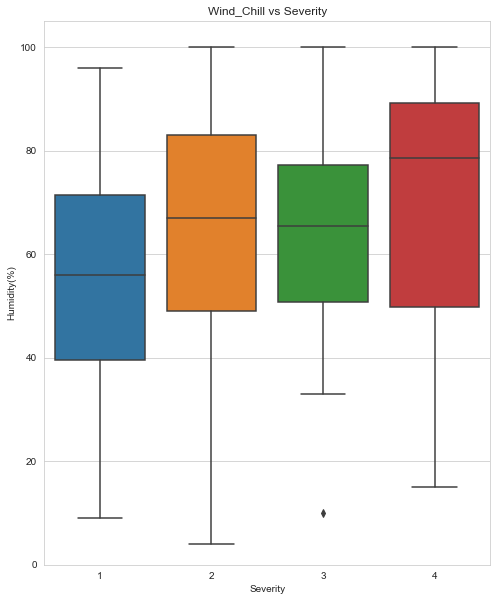

In [32]:
plt.figure(figsize=(8,10))
sns.boxplot(data=sample, y='Humidity(%)', x='Severity').set_title('Wind_Chill vs Severity')
sns.set_style("whitegrid")

plt.ylim(0, 105)
plt.show()

In [33]:
sample['Pressure(in)'].describe()

count    1000.000000
mean       29.449120
std         0.959684
min        20.720000
25%        29.240000
50%        29.760000
75%        29.980000
max        30.470000
Name: Pressure(in), dtype: float64

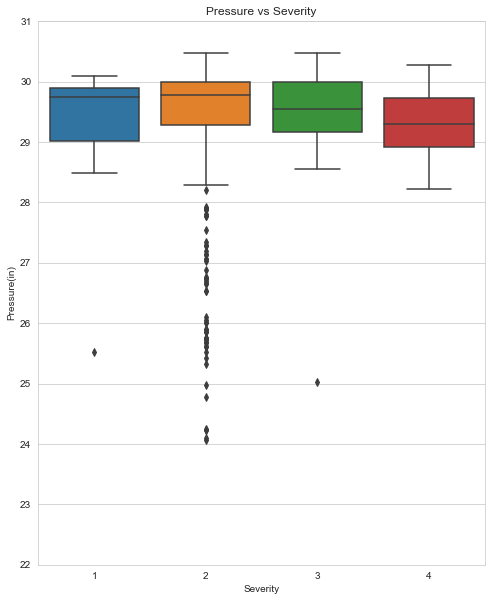

In [34]:
plt.figure(figsize=(8,10))
sns.boxplot(data=sample, y='Pressure(in)', x='Severity').set_title('Pressure vs Severity')

sns.set_style("whitegrid")

plt.ylim(22, 31)
plt.show()

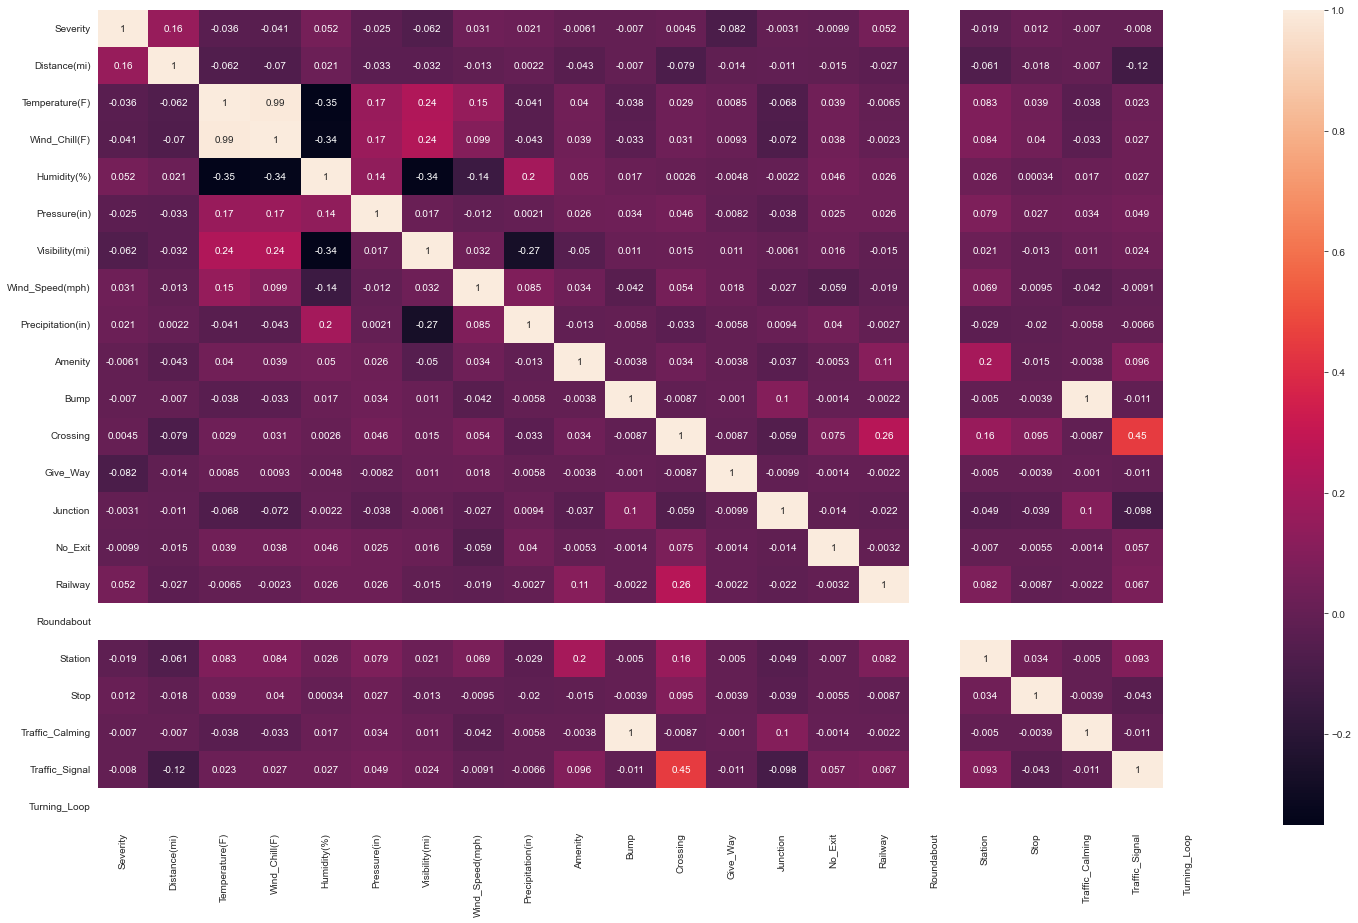

In [35]:
plt.figure(figsize=[25,15])
sns.heatmap(sample.corr(),annot=True)
plt.show()

In [36]:
#Finding effect of time of day on the number of accidents

# day_accidents = accidents[accidents['Sunrise_Sunset']=='Day']
# night_accidents = accidents[accidents['Sunrise_Sunset']=='Night']

# day_accidents_2 = accidents_2[accidents_2['Light_conditions']=='Daylight']
# night_accidents_2 = accidents_2[accidents_2['Light_conditions']=='Darkness - lights lit'] + accidents_2[accidents_2['Light_conditions']=='Darkness - lights unlit'] + accidents_2[accidents_2['Light_conditions']=='Darkness - no lighting']

# day_num = len(day_accidents)+len(day_accidents_2)
# night_num = len(night_accidents)+len(night_accidents_2)
# time_of_day =['Day', 'Night']